<a href="https://colab.research.google.com/github/afvallejo/snPATHOSeq/blob/main/FRP_validation_using_LnCaP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**snPATHO-seq: unlocking the FFPE archives for single nucleus RNA profiling**



Andres F Vallejo<sup>1,2</sup>, Kate Harvey<sup>3</sup>, Taopeng Wang<sup>3,4</sup>, Kellie Wise<sup>1,2</sup>, Lisa M. Butler<sup>2,5</sup>, Jose Polo<sup>1,2</sup>, Jasmine Plummer<sup>6,7</sup>, Alex Swarbrick<sup>3,4,&</sup>, Luciano G Martelotto<sup>1,2,&,#</sup>


1.	ACE – Adelaide Centre for Epigenetics, University of Adelaide, South Australia, Australia. 
2.	SAiGENCI – South Australian immunoGENomics Cancer Institute, University of Adelaide, South Australia, Australia. 
3.	Cancer Ecosystems Program, Garvan Institute of Medical Research, Darlinghurst, NSW 2010, Australia
4.	St Vincent’s Clinical School, Faculty of Medicine and Health, UNSW Sydney, Kensington, NSW 2052, Australia.
5.	Solid Tumour Program, South Australian Health and Medical Research Institute, Adelaide, South Australia, Australia
6.	Department of Biomedical Sciences, Center for Bioinformatics and Functional Genomics, Cedars-Sinai Medical Center, Los Angeles, CA, 90048, USA
7.	Applied Genomics, Computation and Translational Core, Cedars Sinai Medical Center, Los Angeles, CA, 90048, USA

& Joint senior authors
## Correspondence to:
A/Prof. Luciano Martelotto, luciano.martelotto@adelaide.edu.au

## Companion notebook for Figure 1

#Colab

In [ ]:
# restart after installing

#for python 3.7
!pip install scanpy leidenalg pandas==1.1.5 umap-learn==0.5.3 plotnine==0.8.0 anndata==0.7.8 


In [25]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib
import scipy.sparse as sp
from scipy.sparse import issparse

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
from pathlib import Path
from ipywidgets import interactive

sc._settings.ScanpyConfig.n_jobs=4

# Downloading data

In [16]:
%%capture
%%!
wget https://www.dropbox.com/s/j8dbvp2eu67rck4/LnCaP_filtered_data.zip
unzip /content/LnCaP_filtered_data.zip

## Loading the data

In [38]:
adata1 =sc.read('/content/LnCaP_Fresh.h5ad')
adata2 =sc.read('/content/LnCaP_Fixed_FRP.h5ad')
adata1.obs['n_counts'] = adata1.X.sum(1)
adata2.obs['n_counts'] = adata2.X.sum(1)

In [39]:
# Total UMI Fresh
adata1.obs['n_counts'].sum()

86569490.0

In [40]:
# Total UMI Fixed
adata2.obs['n_counts'].sum()

102158570.0

In [41]:
adata=adata1.concatenate(adata2,join = "inner")
sc.pp.filter_genes(adata, min_cells=5)

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# compute qc metrics

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rb'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

adata

AnnData object with n_obs × n_vars = 10805 × 15223
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'batch', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Helper plots for determining gene and count threshold values

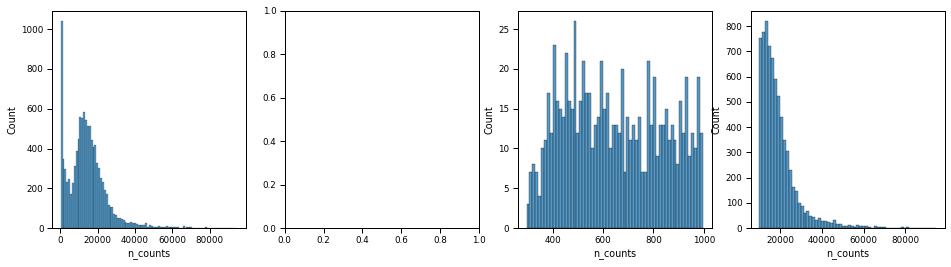

In [42]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<100], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<1000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60, ax=ax4, )

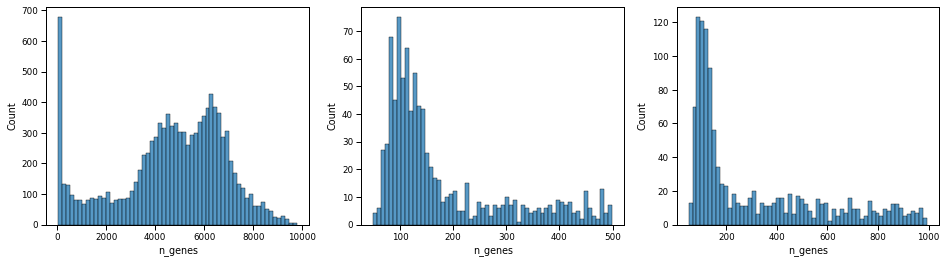

In [43]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<500], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60, ax=ax3,)


... storing 'sample' as categorical
... storing 'group' as categorical


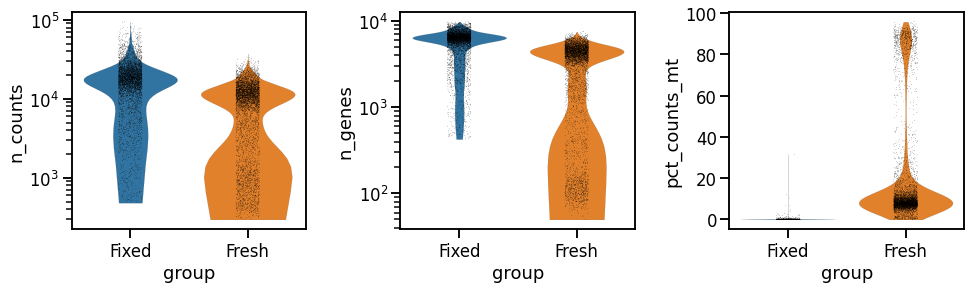

In [44]:
sb.set_context('talk')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.4})

ax1_dict = sc.pl.violin(adata, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(adata, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)
ax3_dict = sc.pl.violin(adata, 'pct_counts_mt', groupby='group',size=0.5, ax=ax3, show=False,)


## Top expressed genes in Fresh

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


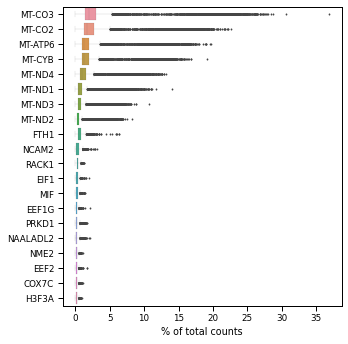

In [45]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.highest_expr_genes(adata[adata.obs.group == 'Fresh'], n_top=20)

## Top expressed genes in Fixed

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


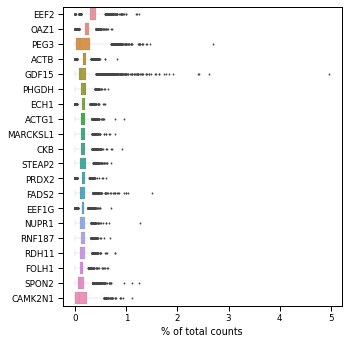

In [46]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.highest_expr_genes(adata[adata.obs.group == 'Fixed'], n_top=20)

# filtering by genes, counts and mito

In [47]:
def h(counts=1000, genes=500,mito=15):
    conditions = [
        (adata.obs['predicted_doublet'] == True),#Doublet
        (adata.obs['n_counts'] < counts),#Low_nCounts
        (adata.obs['n_genes'] < genes),#Low_ngenes
        (adata.obs['pct_counts_mt'] >mito),#High_MT
        (adata.obs['pct_counts_mt'] <= mito) & (adata.obs['n_counts'] >= counts) & (adata.obs['n_genes'] >= genes)& (adata.obs['predicted_doublet'] != True)]#Passing
    values = ['Doublet', 'Low_nCounts', 'Low_ngenes','High_MT', 'Passing']
    adata.obs['QC'] = np.select(conditions, values)
    adata.obs['QC'] = adata.obs['QC'].astype('category')

    new_df1=pd.DataFrame(adata.obs['QC'].value_counts()).reset_index()
    p=sb.barplot(x='index',y='QC',data=new_df1,color='sandybrown')


interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1000, description='counts', max=2000, step=20), IntSlider(value=500, des…

# Nomalization

In [48]:
adata = adata[adata.obs['QC'] == 'Passing']
adata.layers["sqrt_norm"] = np.sqrt(
sc.pp.normalize_total(adata, inplace=False)["X"])
sc.experimental.pp.recipe_pearson_residuals(adata,n_top_genes=1000,n_comps=100,random_state=42,inplace=True)
adata.layers["normalized"]=adata.X
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X

adata

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 9272 × 15223
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'batch', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'sqrt_norm', 'normalized', 'logcounts'

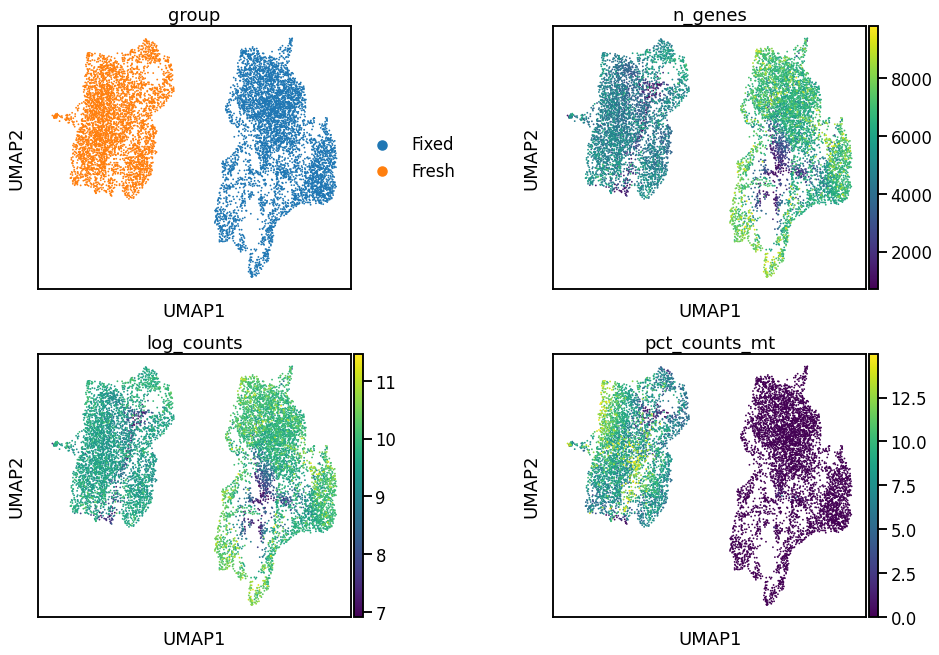

In [49]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=10,random_state=42)
genes_to_plot = ['group','n_genes','log_counts','pct_counts_mt']
sc.tl.umap(adata,random_state=42)
sc.pl.umap(adata,wspace=0.5, color = genes_to_plot,ncols=2)

# Ploting genes

In [50]:
genes_to_plot=['group','ETV1','SPON2','ATN1','MKI67']

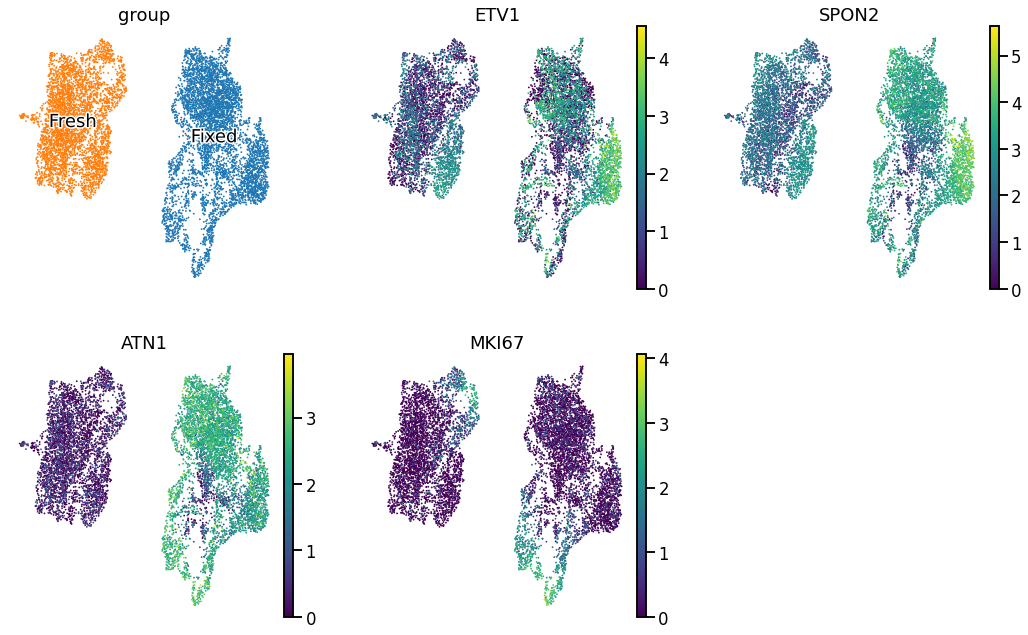

In [51]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=genes_to_plot,ncols=3,legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False)